# Importing the dependencies

In [ ]:
!pip install shap

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder,MinMaxScaler,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from scipy.stats import skew,yeojohnson,boxcox
import os
import shap
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading the dataset
df = pd.read_csv('/content/Combined_CleanData_V3.csv')

# To see all columns
pd.set_option('display.max_columns', None)
df.head(3)

,property_name,Property_Type,society,sector,price,Price_Per_SQFT,bedRoom,bathroom,balcony,address,floorNum,agePossession,description,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
0,2 BHK Flat in Krishna Colony,flat,maa bhagwati residency,sector 7,0.45,556.0,2.0,2.0,1,"Krishna Colony, Gurgaon, Haryana",4.0,Relatively New,So with lift.Maa bhagwati residency is one of ...,1000.0,0.0,0.0,0.0,0.0,0.0,2.0,28.0
1,2 BHK Flat in Ashok Vihar,flat,apna enclave,sector 3,0.50,855.0,2.0,2.0,1,"46b, Ashok Vihar, Gurgaon, Haryana",1.0,Old Property,"Property situated on main road, railway statio...",722.0,0.0,0.0,0.0,0.0,0.0,2.0,37.0
2,2 BHK Flat in Sohna,flat,tulsiani easy in homes,sector 1,0.40,747.0,2.0,2.0,3,"Sohna, Gurgaon, Haryana",12.0,New Property,"This property is 15 km away from badshapur, gu...",661.0,0.0,0.0,0.0,0.0,0.0,1.0,36.0


In [4]:
# Dropping unnecesary features
df.drop(['society','Price_Per_SQFT','property_name','address','description'],axis=1,inplace=True)

In [5]:
# Lets discretize the luxury score feature
def Discretize_luxury(score):
    if 0 <= score < 50:
        return "Low"
    elif 50 <= score < 150:
        return "Medium"
    elif 150 <= score <= 175:
        return "High"
    else:
        return None  # In case the score is outside the specified bins

df['luxury_category'] = df['luxury_score'].apply(Discretize_luxury)

In [6]:
# Lets discretize the floor number feature
def Discretize_floorNum(floor):
    if 0 <= floor <= 2:
        return "Low Floor"
    elif 3 <= floor <= 10:
        return "Mid Floor"
    elif 11 <= floor <= 51:
        return "High Floor"
    else:
        return None  # In case the floor number is outside of the specified bins

df.reset_index(drop=True,inplace=True)
df['floor_category'] = df['floorNum'].apply(Discretize_floorNum)
df['floor_category'].fillna(df['floor_category'].mode()[0],inplace=True)

In [7]:
# Removing features as they are now of no use
df.drop(['floorNum','luxury_score'],axis=1,inplace=True)

Before applying the feature selection techniques we need to make sure that all the features are numerical so for that we need to first encode the categorircal features.

- Nominal encoding : Property_Type
- Ordinal encoding: agePossession,luxury_category,floor_category

In [8]:
df['sector'].value_counts()

sector 1      266
sector 33     127
sector 102    113
sector 85     109
sector 70     107
             ... 
sector 80       5
sector 21       4
sector 13       4
sector 73       3
sector 27       2
Name: sector, Length: 95, dtype: int64

In [9]:
df['sector'].replace('sohna road','sector 33',inplace=True)

# Extracting the sector number for sector feature
for i in range(len(df)):
    item = df['sector'].iloc[i]
    if type(item) == str:
      df.loc[i, 'sector'] = float(item.split()[1])

df['sector'] = df['sector'].astype(float)

In [10]:
high_floor_price = df[df['floor_category'] == 'High Floor']['price'].describe()
low_floor_price = df[df['floor_category'] == 'Low Floor']['price'].describe()
Mid_floor_price = df[df['floor_category'] == 'Mid Floor']['price'].describe()
Temp_df = pd.concat([high_floor_price,low_floor_price,Mid_floor_price],axis=1,keys=['High','Low','Mid'])
Temp_df

,High,Low,Mid
count,831.000000,944.000000,1855.000000
mean,2.010529,2.685074,2.335574
std,1.535534,3.047803,2.655049
min,0.170000,0.070000,0.200000
25%,1.080000,0.850000,0.925000
50%,1.550000,1.440000,1.500000
75%,2.470000,3.250000,2.445000
max,15.000000,19.500000,20.000000


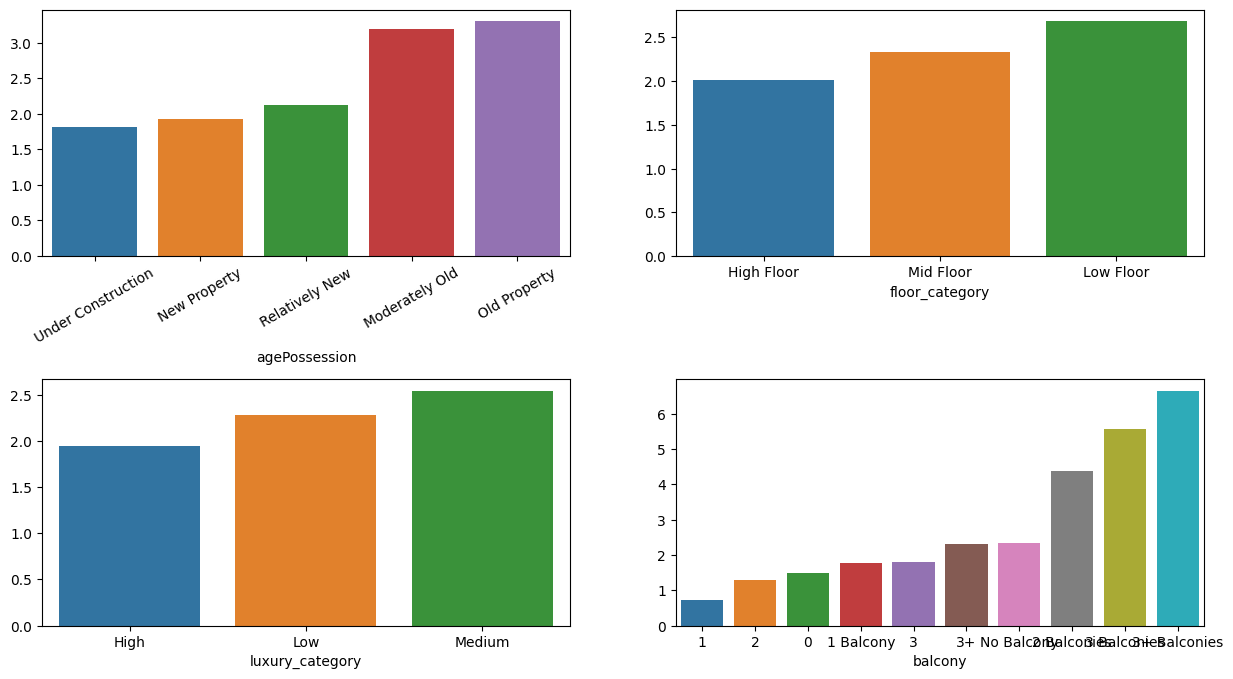

In [11]:
# Performing group by operation to see order of agePossesion, luxury and floor_category feature for ordinal encoding
Price_comparision_ap = df.groupby('agePossession')['price'].mean()
Price_comparision_ap = Price_comparision_ap.sort_values()

Price_comparision_fc = df.groupby('floor_category')['price'].mean()
Price_comparision_fc = Price_comparision_fc.sort_values()

Price_comparision_lc = df.groupby('luxury_category')['price'].mean()
Price_comparision_lc = Price_comparision_lc.sort_values()

Price_comparision_balcony = df.groupby('balcony')['price'].mean()
Price_comparision_balcony = Price_comparision_balcony.sort_values()

fig,ax = plt.subplots(2,2,figsize = (15,8))

sns.barplot(x = Price_comparision_ap.index,y =Price_comparision_ap.values,ax = ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=30)
sns.barplot(x = Price_comparision_fc.index,y =Price_comparision_fc.values,ax = ax[0][1])

sns.barplot(x = Price_comparision_lc.index,y =Price_comparision_lc.values,ax = ax[1][0])
sns.barplot(x = Price_comparision_balcony.index,y =Price_comparision_balcony.values,ax = ax[1][1])

plt.subplots_adjust(hspace=0.5)
plt.show()

# Train,test and validation split

In [47]:
# Seperating the data into dependent variable and indepenedent variables
X = df.drop(['price'],axis=1)
y = df['price']

X_train,X_test_val,y_train,y_test_val = train_test_split(X,y,train_size = 0.8,shuffle=True)
X_test,X_val,y_test,y_val = train_test_split(X_test_val,y_test_val,train_size=0.8,shuffle=True)

In [13]:
X_train.shape,X_test.shape,X_val.shape

((2904, 15), (580, 15), (146, 15))

In [14]:
yeojohnson(X_train['built_up_area'])[1]

0.3459058773225253

In [15]:
log_transformation = X_train['built_up_area'].apply(np.log1p)
cr_transformation = X_train['built_up_area'].apply(np.cbrt)
sqrt_transformation = X_train['built_up_area'].apply(np.sqrt)
yeo_johnson_transformation, lambda_val = yeojohnson(X_train['built_up_area'])
yeojohn_series = pd.Series(yeo_johnson_transformation)

skew_dict = {
    'Normal': skew(X_train['built_up_area']),
    'Log': skew(log_transformation),
    'Sqrt': skew(sqrt_transformation),
    'Cube Root': skew(cr_transformation),
    'Yeo-Johnson': skew(yeojohn_series)
}
skew_dict

{'Normal': 2.0706404467415136,
 'Log': -1.2695907174108507,
 'Sqrt': 0.5990847467852709,
 'Cube Root': 0.06642702722093055,
 'Yeo-Johnson': 0.11126192044745277}

In [16]:
# Applying cube root transformation
X_train['built_up_area'] = X_train['built_up_area'].apply(lambda x: np.cbrt(x) if x >= 0 else np.nan)

# Creating a data processing pipeline
In the pipeline we have to add column transformers for doing ordinal encoding and feature scaling, also we will caching the pipeline to save the repeated computation.

The `memory` parameter of the Pipeline class in scikit-learn is used to specify a directory where the fitted transformers of the pipeline can be cached. This can be useful for saving time when training the pipeline, especially if the transformers are computationally expensive to fit.To use the memory parameter, simply pass the path to a directory to the constructor of the Pipeline class. For example, the following code will create a pipeline with the memory parameter set to the directory `/tmp/pipeline_cache`

If the memory parameter is set, the fitted transformers of the pipeline will be cached in the specified directory. This means that the next time you fit the pipeline to the same data, the transformers will not need to be fitted again. This can save a significant amount of time, especially if the transformers are computationally expensive to fit.

In [17]:
X_train.head(2)

,Property_Type,sector,bedRoom,bathroom,balcony,agePossession,built_up_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_category,floor_category
346,flat,92.0,2.0,2.0,2,New Property,10.269347,0.0,0.0,0.0,0.0,0.0,2.0,Low,Low Floor
3016,Independent_house,3.0,3.0,3.0,No Balcony,Moderately Old,4.820285,0.0,0.0,0.0,0.0,0.0,2.0,Low,Low Floor


In [48]:
# Column transformer for doing ordinal and nominal encoding
encoding_transformer = ColumnTransformer(transformers = [('Encode_PropT',OneHotEncoder(handle_unknown='ignore'),[0]),

                                                         ('Encode_balcony',OrdinalEncoder(categories=[Price_comparision_balcony.index],
                                                        handle_unknown="use_encoded_value",unknown_value = np.nan),[4]),

                                                        ('Encode_AgeP',OrdinalEncoder(categories=[Price_comparision_ap.index],
                                                        handle_unknown="use_encoded_value",unknown_value = np.nan),[5]),

                                                         ('Encode_Lux',OrdinalEncoder(categories=[['Low','Medium','High']],
                                                        handle_unknown="use_encoded_value",unknown_value = np.nan),[13]),

                                                         ('Encode_Floor',OrdinalEncoder(categories=[Price_comparision_fc.index],
                                                    handle_unknown="use_encoded_value",unknown_value = np.nan),[14])],remainder='passthrough')


# Column transformer for doing feature scaling
scaling_transformer = ColumnTransformer(transformers = [('MinMaxScaling',MinMaxScaler(copy=False),[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
                                                       ],remainder='passthrough')


# Stacking column transformers to create a pipeline
pipeline = Pipeline(steps = [('Ordinal Encoding',encoding_transformer),
                            ('Feature scaling',scaling_transformer)],memory='Temp')

In [49]:
# Processing the input data
X_train = pipeline.fit_transform(X_train,y_train)
X_test = pipeline.transform(X_test)

In [50]:
Cols_After_Processing = [
    "Property_Type_flat","Property_Type_IH","balcony","age Possession","Luxury_category","floor_category","sector","bedRoom","bathroom",
    "built_up_area","study room","servant room","store room","pooja room","others","furnishing_type"]

# Again creating a dataframe for further analysis and feature selection
X_train = pd.DataFrame(X_train,columns = Cols_After_Processing)
X_test = pd.DataFrame(X_test,columns = Cols_After_Processing)

# Feature selection
In the previous modules we have already done outlier removal and missing value imputation, so now we will simply focus on feature selection,model building and evaluation of the model. Just for the documentation purpose let me define what is feature selection.

**FEATURE SELECTION** It is a part of feature engineering and in this the main intuition is to simply select most important features from existing set of features, so that we can avoid curse of dimensionality, problem of multicollinearity and reduce any extra computation. Now the thing is that for doing feature selection there are 3 differnt method we can use, but to be more precise we will be utilizing various techniques and we will then consider the results of all the techniques to decide which features to consider and which one to ignore.

In [22]:
X_train.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)

In [23]:
Temp_df = pd.concat([X_train,y_train],axis=1)

### Method 1: Correlation analysis
The `to_frame()` function in Python is used to convert a Pandas Series object to a Pandas DataFrame object.

In [24]:
Corr_df = Temp_df.corr()['price'].to_frame().reset_index().rename(columns={'index':'Features','price':'Correlation_Coefficient'})
Corr_df

,Features,Correlation_Coefficient
0,Property_Type_flat,0.491037
1,Property_Type_IH,-0.491037
2,balcony,0.539343
3,age Possession,0.170766
4,Luxury_category,-0.015735
5,floor_category,0.082177
6,sector,-0.130879
7,bedRoom,0.552923
8,bathroom,0.591065
9,built_up_area,0.661772


### Method 2: Random Forest Feature Importance

In [25]:
Rf_Model = RandomForestRegressor(n_estimators=100, random_state=42)
Rf_Model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [26]:
Rf_Model_FI_df = pd.DataFrame({'Features': X_train.columns,'RF_Importance': Rf_Model.feature_importances_})
Rf_Model_FI_df.sort_values(by='RF_Importance', inplace=True, ascending=False)
Rf_Model_FI_df

,Features,RF_Importance
9,built_up_area,0.627652
2,balcony,0.116835
6,sector,0.110561
7,bedRoom,0.020407
8,bathroom,0.019986
11,servant room,0.017455
1,Property_Type_IH,0.017227
3,age Possession,0.017040
0,Property_Type_flat,0.013886
15,furnishing_type,0.008714


### Method 3 : Gradient Boosting Feature importances

In [27]:
Gb_Model = GradientBoostingRegressor()
Gb_Model.fit(X_train, y_train)

Gb_Model_FI_df = pd.DataFrame({'Features': X_train.columns,'GB_Importance': Gb_Model.feature_importances_})
Gb_Model_FI_df.sort_values(by='GB_Importance', inplace=True, ascending=False)
Gb_Model_FI_df

,Features,GB_Importance
9,built_up_area,0.680331
2,balcony,0.128854
6,sector,0.108059
7,bedRoom,0.023624
8,bathroom,0.022648
11,servant room,0.020435
3,age Possession,0.004522
13,pooja room,0.002720
15,furnishing_type,0.002696
1,Property_Type_IH,0.002149


### Method 4 - Permutation Importance

In [28]:
# Calculate Permutation Importance
Perm_importance = permutation_importance(Rf_Model, X_test, y_test, n_repeats=30, random_state=42)

Perm_importance_df = pd.DataFrame({'Features': X_train.columns,'Perm_importance': Perm_importance.importances_mean})
Perm_importance_df.sort_values(by='Perm_importance', inplace=True, ascending=False)
Perm_importance_df

,Features,Perm_importance
6,sector,1.291333
2,balcony,0.338804
1,Property_Type_IH,0.121421
3,age Possession,0.042088
8,bathroom,0.017305
0,Property_Type_flat,0.009212
14,others,0.002284
9,built_up_area,0.000000
4,Luxury_category,-0.004186
15,furnishing_type,-0.007027


### Method 5: SHAP

In [29]:
explainer = shap.TreeExplainer(Rf_Model)
shap_values = explainer.shap_values(X_train)

# Summing the absolute SHAP values across all samples to get an overall measure of feature importance
shap_sum = np.abs(shap_values).mean(axis=0)

Shap_df = pd.DataFrame({'Features': X_train.columns,'Shap_importance': np.abs(shap_values).mean(axis=0)})
Shap_df.sort_values(by='Shap_importance', inplace=True, ascending=False)
Shap_df

,Features,Shap_importance
9,built_up_area,1.170315
6,sector,0.406611
2,balcony,0.381032
8,bathroom,0.102655
11,servant room,0.072731
1,Property_Type_IH,0.062045
0,Property_Type_flat,0.050934
7,bedRoom,0.044131
3,age Possession,0.033780
15,furnishing_type,0.022149


### Method 6: Recrusive feature elimination

In [30]:
X_train.shape

(2904, 16)

In [31]:
# Apply RFE on the label-encoded and standardized training data
selector_label = RFE(Rf_Model, n_features_to_select=X_train.shape[1], step=1)
selector_label = selector_label.fit(X_train, y_train)

# Get the selected features based on RFE
selected_features = X_train.columns[selector_label.support_]

# Extract the coefficients for the selected features from the underlying linear regression model
selected_coefficients = selector_label.estimator_.feature_importances_

# Organize the results into a DataFrame
RFE_df = pd.DataFrame({'Features': selected_features,'RFE_importance': selected_coefficients})
RFE_df.sort_values(by='RFE_importance', inplace=True, ascending=False)
RFE_df

,Features,RFE_importance
9,built_up_area,0.627652
2,balcony,0.116835
6,sector,0.110561
7,bedRoom,0.020407
8,bathroom,0.019986
11,servant room,0.017455
1,Property_Type_IH,0.017227
3,age Possession,0.017040
0,Property_Type_flat,0.013886
15,furnishing_type,0.008714


In [32]:
# Merging the results of all the techniques into single data frame
FI_df = Corr_df.merge(Rf_Model_FI_df,on='Features').merge(Gb_Model_FI_df,on='Features').merge(Perm_importance_df,on='Features').merge(Shap_df,on='Features').merge(RFE_df,on='Features')

# Extracting only the technique values
FI_df_Results = FI_df[FI_df.columns[1:]]

# Let's normalize the values
FI_df_Results = FI_df_Results.divide(FI_df_Results.sum(axis=0), axis=1)
FI_df_Results.insert(0,'Features',FI_df['Features'])
FI_df_Results

,Features,Correlation_Coefficient,RF_Importance,GB_Importance,Perm_importance,Shap_importance,RFE_importance
0,Property_Type_flat,0.132750,0.013886,0.001002,0.006033,0.021132,0.013886
1,Property_Type_IH,-0.132750,0.017227,0.002149,0.079516,0.025742,0.017227
2,balcony,0.145810,0.116835,0.128854,0.221874,0.158085,0.116835
3,age Possession,0.046166,0.017040,0.004522,0.027563,0.014015,0.017040
4,Luxury_category,-0.004254,0.006282,0.000132,-0.002741,0.004805,0.006282
5,floor_category,0.022216,0.007482,0.001361,-0.015354,0.006649,0.007482
6,sector,-0.035383,0.110561,0.108059,0.845663,0.168698,0.110561
7,bedRoom,0.149481,0.020407,0.023624,-0.080228,0.018309,0.020407
8,bathroom,0.159792,0.019986,0.022648,0.011332,0.042590,0.019986
9,built_up_area,0.178908,0.627652,0.680331,0.000000,0.485549,0.627652


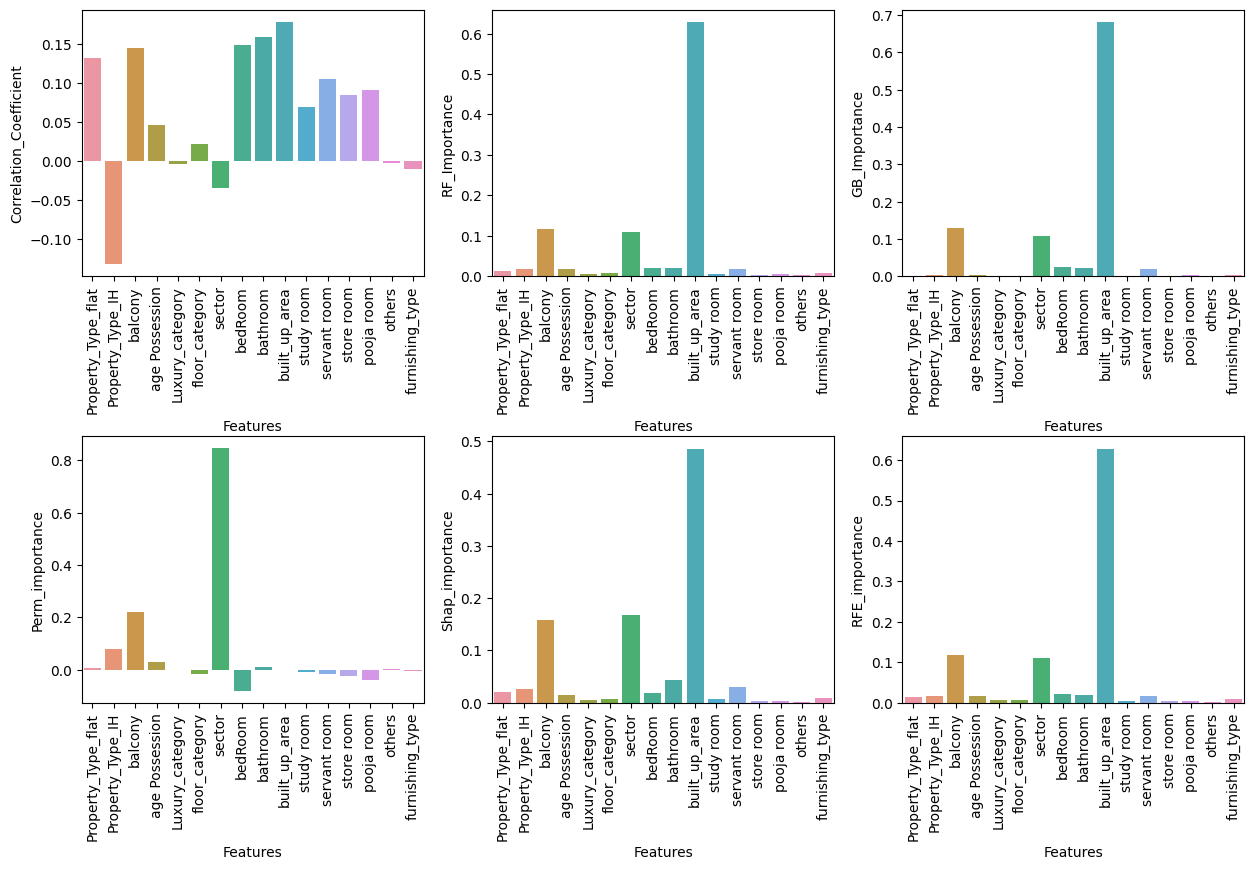

In [33]:
fig,ax = plt.subplots(2,3,figsize = (15,9))

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['Correlation_Coefficient'],ax = ax[0][0])
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['RF_Importance'],ax = ax[0][1])
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['GB_Importance'],ax = ax[0][2])
ax[0][2].set_xticklabels(ax[0][2].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['Perm_importance'],ax = ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['Shap_importance'],ax = ax[1][1])
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=90)

sns.barplot(x =FI_df_Results['Features'],y = FI_df_Results['RFE_importance'],ax = ax[1][2])
ax[1][2].set_xticklabels(ax[1][2].get_xticklabels(), rotation=90)

plt.subplots_adjust(hspace=0.6)
plt.show()

In [34]:
FI_df_Results['Average_Coeff'] = FI_df_Results[FI_df_Results.columns[2:]].mean(axis=1)
FI_df_Results[['Features','Average_Coeff']].sort_values(by='Average_Coeff')

,Features,Average_Coeff
13,pooja room,-0.004381
12,store room,-0.002536
7,bedRoom,0.000504
14,others,0.001519
5,floor_category,0.001524
10,study room,0.001710
4,Luxury_category,0.002952
15,furnishing_type,0.004942
0,Property_Type_flat,0.011188
11,servant room,0.013419


In [35]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)

Scores_Before_Removing = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2').mean()
Scores_After_Removing = cross_val_score(rf, X_train.drop(columns=['others','pooja room','study room']), y_train, cv=5, scoring='r2').mean()

print('Before : ',Scores_Before_Removing)
print('After : ',Scores_After_Removing)
print('Difference : ',Scores_Before_Removing-Scores_After_Removing)

Before :  0.8136378844860331
After :  0.8138518830443928
Difference :  -0.00021399855835968484


In [51]:
X_train.drop(['others','pooja room','study room'],axis=1,inplace=True)
X_test.drop(['others','pooja room','study room'],axis=1,inplace=True)

In [55]:
# Dropping the features
X_train.drop(['store room'],axis=1,inplace=True)
X_test.drop(['store room'],axis=1,inplace=True)

In [37]:
X_train.head(4)

,Property_Type_flat,Property_Type_IH,balcony,age Possession,Luxury_category,floor_category,sector,bedRoom,bathroom,built_up_area,servant room,store room,furnishing_type
0,0.0,1.0,0.111111,0.25,0.0,1.0,0.812500,0.125,0.125,0.404785,0.0,0.0,1.0
1,1.0,0.0,0.666667,0.75,0.0,1.0,0.017857,0.250,0.250,0.096818,0.0,0.0,1.0
2,0.0,1.0,0.555556,0.50,0.0,0.5,0.794643,0.375,0.375,0.537057,0.0,0.0,0.5
3,0.0,1.0,0.111111,0.50,0.5,0.5,0.589286,0.125,0.125,0.440582,0.0,0.0,1.0


# Base line moddel

In [56]:
model = SVR(kernel='rbf')

# Training the model
model.fit(X_train,y_train)

# K-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(model, X_test, y_test, cv=kfold, scoring='r2')

In [57]:
print("Average R2 Score : ",scores.mean())

Average R2 Score :  0.6226656473063701


In [54]:
y_pred = model.predict(X_test)
mean_absolute_error(y_pred,y_test)

0.7368719000413108

Currently with the base configuration our model is performing average. So now our main aim will be to increase the performance of our machine learning model by doing model selection and hyper-parameter optimization.

In [59]:
df.drop(['others','pooja room','study room'],axis=1,inplace=True)
df.head(4)

,Property_Type,sector,price,bedRoom,bathroom,balcony,agePossession,built_up_area,servant room,store room,furnishing_type,luxury_category,floor_category
0,flat,7.0,0.45,2.0,2.0,1,Relatively New,1000.0,0.0,0.0,2.0,Low,Mid Floor
1,flat,3.0,0.50,2.0,2.0,1,Old Property,722.0,0.0,0.0,2.0,Low,Low Floor
2,flat,1.0,0.40,2.0,2.0,3,New Property,661.0,0.0,0.0,1.0,Low,High Floor
3,flat,61.0,1.47,2.0,2.0,2,Under Construction,1333.0,0.0,0.0,1.0,Medium,Low Floor


In [60]:
df.to_csv('ombined_CleanData_V4.csv',index=False)